# **XI UIMP Summer School on Integrative Synthetic Biology.** 
*La ingeniería de la biología como tecnología transformadora*

## AI & ML-based synbio design applications

Outline:

* Quantitative data-driven: Predictive models of ribosome binding sites
* Qualitate data-driven: Predictive models of promoter libraries
* Context-aware hybrid mechanistic: Biosensors
* Generative: Enzyme sequence variants



## 1. Quantitative data-driven SynBio AI

In this first example, we will consider a case where a genetic circuit for bio-based production contains several genes that are regulated by ribosome binding-site (RBS) motifs. We don't have a prior knowledge about the strength of the RBS, but we will assume that they consitently express the genes in the combinatorial library.

Our example will be based on the limonene pathway production {ref}, where the target genes will be the last two commited steps in the pathway.

For each gene, we have 20 RBS motifs available. This will create a library of $20 \times 20 = 400$ possible combinations.

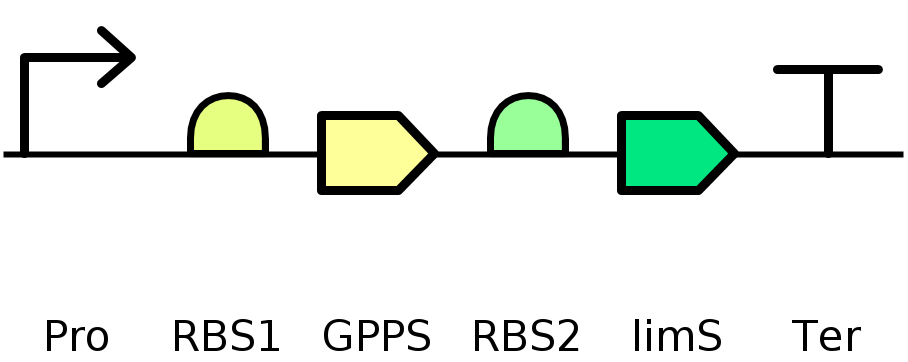

